#### Top

# Chapter 3 String Manipulation

* [Introduction](#Introduction)
* [3.0 Imports and Setup](#3.0-Imports-and-Setup)
* [3.1 Twitter Data](#3.1-Twitter-Data)
* [3.2 Validating the Data](#3.2-Validating-the-Data)
* [3.3 Extracting the Username](#3.3-Extracting-the-Username)
    - [3.3.1: `.list`](#3.3.1:-.list)
    - [3.3.2: `.list.join`](#3.3.2:-.list.join)
    - [3.3.3: `.map_elements`](#3.3.3:-.map_elements)
    - [3.3.4: index access](#3.3.4:-index-access)
* [3.4 Extract the Username with Regex](#3.4-Extract-the-Username-with-Regex)
* [3.5 Counting Words and Mentions](#3.5-Counting-Words-and-Mentions)
* [3.6 Checking for Emojis](#3.6-Checking-for-Emojis)
* [3.7 Plotting Trends](#3.7-Plotting-Trends)
    - [3.7.1 hvPlot](#3.7.1-hvPlot)
    - [3.7.2 matplotlib](#3.7.2-matplotlib)
    - [3.7.3 pandas plot](#3.7.3-pandas-plot)

---


# Introduction
[back to Top](#Top)

Polars provides efficient and powerful string manipulation capabilities through its expressive API and vectorized operations. Here are some key points about string manipulation in Polars:

- Polars has a dedicated `pl.col("column_name").str` namespace for string operations, similar to pandas' `df["column"].str`.

- Common string operations like `contains`, `starts_with`, `ends_with`, `replace`, `split`, `slice`, `to_uppercase`, `to_lowercase` etc. are available as methods under `str`.

- Regular expressions can be used with methods like `str.contains(r"regex")` or `str.replace(r"regex", "new_value")`.

- Vectorized string operations allow applying functions over entire columns efficiently without needing loops.

- The `str.extract` method allows extracting substrings matching a regex pattern into new columns.

- String operations can be chained together using Polars' method chaining syntax, e.g. `pl.col("text").str.replace(" ", "_").str.slice(0, 10)`.

- Polars supports Unicode strings and provides methods like `str.is_ascii` to check for ASCII characters.

So in summary, Polars provides a comprehensive set of vectorized string manipulation capabilities through its intuitive `str` namespace, allowing efficient processing of large text datasets.

---

**Limitations of Polars string manipulation**

Polars provides powerful and efficient string manipulation capabilities through its `str` namespace, but there are a few limitations to be aware of:

1. Regular expression support is currently limited compared to Python's built-in re module. Complex regex patterns involving lookahead/lookbehind may not work as expected.

2. Some less common string operations like `zfill`, `ljust`, `rjust` etc. are not available out-of-the-box in Polars. You may need to use Python's string methods or implement custom functions.

3. String operations on very large datasets can still be memory intensive, as Polars loads all data into memory by default. For huge text datasets, you may need to use Polars' streaming capabilities.

4. Polars does not have a built-in string tokenizer or ability to extract ngrams from text data. You'd need to use external libraries like NLTK for such text processing tasks.

5. String encoding handling is currently limited in Polars. It assumes UTF-8 encoding by default and may not handle other encodings correctly.

Overall, while Polars covers most common string manipulation needs very efficiently, it may lack some advanced text processing capabilities compared to dedicated Python libraries like pandas, re or NLTK. But its core string operations are highly optimized and vectorized for performance.

---
# 3.0 Imports and Setup

[back to Top](#Top)


In [1]:
import polars as pl
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline
import chardet
import pprint as pp
import hvplot.polars
hvplot.extension('matplotlib')

matplotlib_inline.backend_inline.set_matplotlib_formats("retina")
pd.options.mode.copy_on_write = True
print(pd.options.mode.copy_on_write)
pl.Config.set_verbose(True)
pl.show_versions()

def HR():
    print("-"*40)

@pl.Config(tbl_cols=-1, ascii_tables=True)
def tight_layout(df: pl.DataFrame, n=5) -> None:
    with pl.Config(tbl_cols=-1, fmt_str_lengths=n):
        print(df)

def detect_encoding(filename: str) -> str:
    """Return the most probable character encoding for a file."""
    with open(filename, "rb") as f:
        raw_data = f.read()
        print(raw_data)
        result = chardet.detect(raw_data)
        return result["encoding"]

True
--------Version info---------
Polars:              1.9.0
Index type:          UInt32
Platform:            macOS-12.7.6-x86_64-i386-64bit
Python:              3.11.5 (main, Jan 16 2024, 17:25:53) [Clang 14.0.0 (clang-1400.0.29.202)]

----Optional dependencies----
adbc_driver_manager  1.1.0
altair               5.4.0
cloudpickle          3.0.0
connectorx           0.3.3
deltalake            0.19.1
fastexcel            0.11.6
fsspec               2023.12.2
gevent               24.2.1
great_tables         0.10.0
matplotlib           3.9.2
nest_asyncio         1.6.0
numpy                2.0.2
openpyxl             3.1.5
pandas               2.2.2
pyarrow              17.0.0
pydantic             2.8.2
pyiceberg            0.6.1
sqlalchemy           2.0.32
torch                <not installed>
xlsx2csv             0.8.3
xlsxwriter           3.2.0


---
# 3.1 Twitter Data

[back to Top](#Top)

In [2]:
url = 'https://github.com/mattharrison/datasets/raw/master/data/__mharrison__2020-2021.csv'
url_file = './data/__mharrison__2020-2021.csv'

!wget -P ./data/ -nc $url

raw = pl.read_csv(url_file)
print(raw.columns)
raw.head(3)

--2024-10-25 10:56:59--  https://github.com/mattharrison/datasets/raw/master/data/__mharrison__2020-2021.csv
github.com (github.com) をDNSに問いあわせています... 20.27.177.113
github.com (github.com)|20.27.177.113|:443 に接続しています... 接続しました。
HTTP による接続要求を送信しました、応答を待っています... 302 Found
場所: https://raw.githubusercontent.com/mattharrison/datasets/master/data/__mharrison__2020-2021.csv [続く]
--2024-10-25 10:57:00--  https://raw.githubusercontent.com/mattharrison/datasets/master/data/__mharrison__2020-2021.csv
raw.githubusercontent.com (raw.githubusercontent.com) をDNSに問いあわせています... 185.199.109.133, 185.199.110.133, 185.199.111.133, ...
raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443 に接続しています... 接続しました。
HTTP による接続要求を送信しました、応答を待っています... 200 OK
長さ: 1725101 (1.6M) [text/plain]
`./data/__mharrison__2020-2021.csv' に保存中

__mharrison__2020-2 100%[===================>]   1.64M  3.91MB/s 時間 0.4s       

2024-10-25 10:57:01 (3.91 MB/s) - `./data/__mharrison__2020-2021.csv' へ保存完了 [1725101/172

avg line length: 250.46191
std. dev. line length: 86.68226
initial row estimate: 6908
no. of chunks: 4 processed by: 4 threads.


Tweet id,Tweet permalink,Tweet text,time,impressions,engagements,engagement rate,retweets,replies,likes,user profile clicks,url clicks,hashtag clicks,detail expands,permalink clicks,app opens,app installs,follows,email tweet,dial phone,media views,media engagements,promoted impressions,promoted engagements,promoted engagement rate,promoted retweets,promoted replies,promoted likes,promoted user profile clicks,promoted url clicks,promoted hashtag clicks,promoted detail expands,promoted permalink clicks,promoted app opens,promoted app installs,promoted follows,promoted email tweet,promoted dial phone,promoted media views,promoted media engagements
i64,str,str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i64,i64,i64,i64,i64,i64,i64,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str
1212580517905780737,"""https://twitter.com/__mharriso…","""Sounds like a great topic! htt…","""2020-01-02 03:44:00+00:00""",1465.0,7.0,0.004778,0.0,0.0,3.0,3.0,0.0,0.0,1.0,0.0,0,0,0,0,0,0,0,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
1212582494828036097,"""https://twitter.com/__mharriso…","""@FogleBird Looks like SLC. I c…","""2020-01-02 03:52:00+00:00""",154.0,3.0,0.019481,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0,0,0,0,0,0,0,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
1212613735698690049,"""https://twitter.com/__mharriso…","""@afilina That's really amount …","""2020-01-02 05:56:00+00:00""",1024.0,6.0,0.005859,0.0,0.0,1.0,2.0,0.0,0.0,3.0,0.0,0,0,0,0,0,0,0,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null


Select the relevant columns.

In [3]:
def tweak_twit(df):
    return (
        df
        .select(
            ['Tweet id', 'Tweet permalink', 'Tweet text', 'time', 'impressions', 'engagements', 
             'engagement rate', 'retweets', 'replies', 'likes', 'user profile clicks']
        )
    )

In [4]:
twit = tweak_twit(raw)
print(twit.shape)
twit.head(1)

(5791, 11)


Tweet id,Tweet permalink,Tweet text,time,impressions,engagements,engagement rate,retweets,replies,likes,user profile clicks
i64,str,str,str,f64,f64,f64,f64,f64,f64,f64
1212580517905780737,"""https://twitter.com/__mharriso…","""Sounds like a great topic! htt…","""2020-01-02 03:44:00+00:00""",1465.0,7.0,0.004778,0.0,0.0,3.0,3.0


---
# 3.2 Validating the Data
[back to Top](#Top)

* The column expressions have an `.str` accessor, much like Pandas.
* This accessor provides access to string manipulation methods.
* Select the *Tweet permalink* column to test against and validate proper URL.

In [5]:
url_col = pl.col('Tweet permalink')
type(url_col)

polars.expr.expr.Expr

In [6]:
list(enumerate(sorted([x for x in dir(url_col.str) if not x.startswith('_')])))

[(0, 'concat'),
 (1, 'contains'),
 (2, 'contains_any'),
 (3, 'count_matches'),
 (4, 'decode'),
 (5, 'encode'),
 (6, 'ends_with'),
 (7, 'explode'),
 (8, 'extract'),
 (9, 'extract_all'),
 (10, 'extract_groups'),
 (11, 'extract_many'),
 (12, 'find'),
 (13, 'head'),
 (14, 'join'),
 (15, 'json_decode'),
 (16, 'json_path_match'),
 (17, 'len_bytes'),
 (18, 'len_chars'),
 (19, 'pad_end'),
 (20, 'pad_start'),
 (21, 'replace'),
 (22, 'replace_all'),
 (23, 'replace_many'),
 (24, 'reverse'),
 (25, 'slice'),
 (26, 'split'),
 (27, 'split_exact'),
 (28, 'splitn'),
 (29, 'starts_with'),
 (30, 'strip_chars'),
 (31, 'strip_chars_end'),
 (32, 'strip_chars_start'),
 (33, 'strip_prefix'),
 (34, 'strip_suffix'),
 (35, 'strptime'),
 (36, 'tail'),
 (37, 'to_date'),
 (38, 'to_datetime'),
 (39, 'to_decimal'),
 (40, 'to_integer'),
 (41, 'to_lowercase'),
 (42, 'to_time'),
 (43, 'to_titlecase'),
 (44, 'to_uppercase'),
 (45, 'zfill')]

---
Check the overlap of Python and Polars string functionality

In [7]:
list(enumerate(sorted([x for x in set(dir(url_col.str)) & set(dir('')) if not x.startswith('_')])))

[(0, 'encode'),
 (1, 'find'),
 (2, 'join'),
 (3, 'replace'),
 (4, 'split'),
 (5, 'zfill')]

---
Check the extra methods (or methods that are spelled differently, like `.to_uppercase`)

In [8]:
list(enumerate(sorted([x for x in set(dir(url_col.str)) - set(dir('')) if not x.startswith('_')])))

[(0, 'concat'),
 (1, 'contains'),
 (2, 'contains_any'),
 (3, 'count_matches'),
 (4, 'decode'),
 (5, 'ends_with'),
 (6, 'explode'),
 (7, 'extract'),
 (8, 'extract_all'),
 (9, 'extract_groups'),
 (10, 'extract_many'),
 (11, 'head'),
 (12, 'json_decode'),
 (13, 'json_path_match'),
 (14, 'len_bytes'),
 (15, 'len_chars'),
 (16, 'pad_end'),
 (17, 'pad_start'),
 (18, 'replace_all'),
 (19, 'replace_many'),
 (20, 'reverse'),
 (21, 'slice'),
 (22, 'split_exact'),
 (23, 'splitn'),
 (24, 'starts_with'),
 (25, 'strip_chars'),
 (26, 'strip_chars_end'),
 (27, 'strip_chars_start'),
 (28, 'strip_prefix'),
 (29, 'strip_suffix'),
 (30, 'strptime'),
 (31, 'tail'),
 (32, 'to_date'),
 (33, 'to_datetime'),
 (34, 'to_decimal'),
 (35, 'to_integer'),
 (36, 'to_lowercase'),
 (37, 'to_time'),
 (38, 'to_titlecase'),
 (39, 'to_uppercase')]

---
**Validation**

* Validate the urls in the `permalink` column are valid.
* Check if URLs start with `https://twitter.com`
* Use `.str.starts_with()` for this.

In [9]:
# Test
'https://metasnake.com'.startswith('https://twitter.com')

False

In [10]:
# Test
(
    twit
    .filter(url_col.str.starts_with('https://twitter.com/'))
    .head(2)
)

dataframe filtered


Tweet id,Tweet permalink,Tweet text,time,impressions,engagements,engagement rate,retweets,replies,likes,user profile clicks
i64,str,str,str,f64,f64,f64,f64,f64,f64,f64
1212580517905780737,"""https://twitter.com/__mharriso…","""Sounds like a great topic! htt…","""2020-01-02 03:44:00+00:00""",1465.0,7.0,0.004778,0.0,0.0,3.0,3.0
1212582494828036097,"""https://twitter.com/__mharriso…","""@FogleBird Looks like SLC. I c…","""2020-01-02 03:52:00+00:00""",154.0,3.0,0.019481,0.0,0.0,1.0,1.0


In [11]:
# Above works ok, now inverse the logic.
(
    twit
    .filter(~url_col.str.starts_with('https://twitter.com/'))
)

dataframe filtered


Tweet id,Tweet permalink,Tweet text,time,impressions,engagements,engagement rate,retweets,replies,likes,user profile clicks
i64,str,str,str,f64,f64,f64,f64,f64,f64,f64


It looks like every link starts with 'https://twitter.com/'.

---
# 3.3 Extracting the Username

[back to Top](#Top)

* The URLs look like HOST/USER/status/ID
* We can write an expression that extracts the username from the URL.
* We can split the URL on the / character.
* We can also use regex.
* `.str.split()` is analogous to Python's `.split()`
* This returns a *list* column with strings, eg a typed list.

In [12]:
'https://metasnake.com/effective-polars'.split('/')

['https:', '', 'metasnake.com', 'effective-polars']

In [13]:
(
    twit
    .select(url_col.str.split('/'))
)

Tweet permalink
list[str]
"[""https:"", """", … ""1212580517905780737""]"
"[""https:"", """", … ""1212582494828036097""]"
"[""https:"", """", … ""1212613735698690049""]"
"[""https:"", """", … ""1212911749617242113""]"
"[""https:"", """", … ""1212920556028252160""]"
…
"[""https:"", """", … ""1475300661851934721""]"
"[""https:"", """", … ""1475518143690801156""]"
"[""https:"", """", … ""1475891441243025408""]"


---
### 3.3.1: `.list`
[back to Top](#Top)

Just as a string column has a `.str` accessor, it also has a `.list` accessor to access list methods.

In [14]:
list(enumerate(sorted([x for x in dir(url_col.list) if not x.startswith('_')])))

[(0, 'all'),
 (1, 'any'),
 (2, 'arg_max'),
 (3, 'arg_min'),
 (4, 'concat'),
 (5, 'contains'),
 (6, 'count_matches'),
 (7, 'diff'),
 (8, 'drop_nulls'),
 (9, 'eval'),
 (10, 'explode'),
 (11, 'first'),
 (12, 'gather'),
 (13, 'gather_every'),
 (14, 'get'),
 (15, 'head'),
 (16, 'join'),
 (17, 'last'),
 (18, 'len'),
 (19, 'max'),
 (20, 'mean'),
 (21, 'median'),
 (22, 'min'),
 (23, 'n_unique'),
 (24, 'reverse'),
 (25, 'sample'),
 (26, 'set_difference'),
 (27, 'set_intersection'),
 (28, 'set_symmetric_difference'),
 (29, 'set_union'),
 (30, 'shift'),
 (31, 'slice'),
 (32, 'sort'),
 (33, 'std'),
 (34, 'sum'),
 (35, 'tail'),
 (36, 'to_array'),
 (37, 'to_struct'),
 (38, 'unique'),
 (39, 'var')]

---
Here, we get the length of the list. This gives us the number of parts in the URL.

In [15]:
(
    twit
    .select(
        url_col.str.split('/').list.len()
    )
)

Tweet permalink
u32
6
6
6
6
6
…
6
6
6


---
* If we want to convert each part of the list into a column, we need to convert the list into a struct.
* We can then use `.unnest()`
* This puts every item from a struct into its own column.
* `.list.to_struct()` converts each list into a struct.
* You can think of a struct datatype as a record or structured data type (similar to a Python tuple)

In [16]:
# original
twit.select(url_col).head()

Tweet permalink
str
"""https://twitter.com/__mharriso…"
"""https://twitter.com/__mharriso…"
"""https://twitter.com/__mharriso…"
"""https://twitter.com/__mharriso…"
"""https://twitter.com/__mharriso…"


In [17]:
# without converting to a struct
(
    twit
    .select(
        url_col.str.split('/')
    )
).head()

Tweet permalink
list[str]
"[""https:"", """", … ""1212580517905780737""]"
"[""https:"", """", … ""1212582494828036097""]"
"[""https:"", """", … ""1212613735698690049""]"
"[""https:"", """", … ""1212911749617242113""]"
"[""https:"", """", … ""1212920556028252160""]"


In [18]:
# converting to a struct
(
    twit
    .select(
        url_col.str.split('/')
            .list
            .to_struct()
    )
).head()

Tweet permalink
struct[6]
"{""https:"","""",""twitter.com"",""__mharrison__"",""status"",""1212580517905780737""}"
"{""https:"","""",""twitter.com"",""__mharrison__"",""status"",""1212582494828036097""}"
"{""https:"","""",""twitter.com"",""__mharrison__"",""status"",""1212613735698690049""}"
"{""https:"","""",""twitter.com"",""__mharrison__"",""status"",""1212911749617242113""}"
"{""https:"","""",""twitter.com"",""__mharrison__"",""status"",""1212920556028252160""}"


Next, we can use the dataframe's `.unnest()` to convert the struct into columns.

Note that we cannot use `.unnest()` on lists, only on structs.

In [19]:
try:
    print(twit.select(url_col.str.split('/')).unnest('Tweet permalink'))
except Exception as e:
    print(e)

invalid series dtype: expected `Struct`, got `list[str]`


In [20]:
try:
    print(twit.select(url_col.str.split('/').list.to_struct()).unnest('Tweet permalink'))
except Exception as e:
    print(e)

shape: (5_791, 6)
+---------+---------+-------------+---------------+---------+---------------------+
| field_0 | field_1 | field_2     | field_3       | field_4 | field_5             |
| ---     | ---     | ---         | ---           | ---     | ---                 |
| str     | str     | str         | str           | str     | str                 |
+=================================================================================+
| https:  |         | twitter.com | __mharrison__ | status  | 1212580517905780737 |
| https:  |         | twitter.com | __mharrison__ | status  | 1212582494828036097 |
| https:  |         | twitter.com | __mharrison__ | status  | 1212613735698690049 |
| https:  |         | twitter.com | __mharrison__ | status  | 1212911749617242113 |
| https:  |         | twitter.com | __mharrison__ | status  | 1212920556028252160 |
| …       | …       | …           | …             | …       | …                   |
| https:  |         | twitter.com | __mharrison__ | status

---
`.to_struct()` nests the columns of a dataframe into a single series.

In [21]:
print(
    twit
    .select(
        url_col.str.split('/')
        .list.to_struct()
    )
    .unnest('Tweet permalink')
    .to_struct()
)

shape: (5_791,)
Series: '' [struct[6]]
[
	{"https:","","twitter.com","__mharrison__","status","1212580517905780737"}
	{"https:","","twitter.com","__mharrison__","status","1212582494828036097"}
	{"https:","","twitter.com","__mharrison__","status","1212613735698690049"}
	{"https:","","twitter.com","__mharrison__","status","1212911749617242113"}
	{"https:","","twitter.com","__mharrison__","status","1212920556028252160"}
	…
	{"https:","","twitter.com","__mharrison__","status","1475300661851934721"}
	{"https:","","twitter.com","__mharrison__","status","1475518143690801156"}
	{"https:","","twitter.com","__mharrison__","status","1475891441243025408"}
	{"https:","","twitter.com","__mharrison__","status","1476453819751878656"}
	{"https:","","twitter.com","__mharrison__","status","1477024722051158018"}
]


---
### 3.3.2: `.list.join`
[back to Top](#Top)

If we wanted to undo the split (eg convert the list of strings to a single string), we could use `.list.join()`

In [22]:
(
    twit
    .select(
        url_col.str.split('/') # convert single string to list of strings
        .list.join('/') # convert back to a single string
    )
)

Tweet permalink
str
"""https://twitter.com/__mharriso…"
"""https://twitter.com/__mharriso…"
"""https://twitter.com/__mharriso…"
"""https://twitter.com/__mharriso…"
"""https://twitter.com/__mharriso…"
…
"""https://twitter.com/__mharriso…"
"""https://twitter.com/__mharriso…"
"""https://twitter.com/__mharriso…"


In [23]:
# equivalent to this:
(
    twit
    .select(
        url_col
    )
)

Tweet permalink
str
"""https://twitter.com/__mharriso…"
"""https://twitter.com/__mharriso…"
"""https://twitter.com/__mharriso…"
"""https://twitter.com/__mharriso…"
"""https://twitter.com/__mharriso…"
…
"""https://twitter.com/__mharriso…"
"""https://twitter.com/__mharriso…"
"""https://twitter.com/__mharriso…"


---
### 3.3.3: `.map_elements`
[back to Top](#Top)

* We can also convert a struct column to a list column using `.map_elements`
* This is generally slower than Polars expression.

In [24]:
(
    twit
    .select(
        url_col.str.split('/').list.to_struct()
    )
    .select(
        pl.all().map_elements(lambda elem: list(elem), return_dtype=pl.List(pl.String))
    )
)

Tweet permalink
list[str]
"[""field_0"", ""field_1"", … ""field_5""]"
"[""field_0"", ""field_1"", … ""field_5""]"
"[""field_0"", ""field_1"", … ""field_5""]"
"[""field_0"", ""field_1"", … ""field_5""]"
"[""field_0"", ""field_1"", … ""field_5""]"
…
"[""field_0"", ""field_1"", … ""field_5""]"
"[""field_0"", ""field_1"", … ""field_5""]"
"[""field_0"", ""field_1"", … ""field_5""]"


---
* The result of the unnest shows that the username is in the 4th element of the URL.
* We can use `.list.get()` to get index 3 of the list.

In [25]:
(
    twit
    .with_columns(
        username=url_col.str.split('/').list.get(3)
    )
    .select(
        pl.col(['Tweet id', 'Tweet text', 'username'])
    )
)

Tweet id,Tweet text,username
i64,str,str
1212580517905780737,"""Sounds like a great topic! htt…","""__mharrison__"""
1212582494828036097,"""@FogleBird Looks like SLC. I c…","""__mharrison__"""
1212613735698690049,"""@afilina That's really amount …","""__mharrison__"""
1212911749617242113,"""@randal_olson I use anaconda w…","""__mharrison__"""
1212920556028252160,"""@AlSweigart Sometimes the stud…","""__mharrison__"""
…,…,…
1475300661851934721,"""@allison_horst That's awesome!""","""__mharrison__"""
1475518143690801156,"""@willmcgugan You need to find …","""__mharrison__"""
1475891441243025408,"""@posco Visiting Hawaii for the…","""__mharrison__"""


---
### 3.3.4: index access
[back to Top](#Top)

* We can also use *index access* to get the 4th element.

In [26]:
(
    twit
    .with_columns(username=url_col.str.split('/').list[3])
    .select(pl.col(['Tweet id', 'Tweet text', 'username']))
)

Tweet id,Tweet text,username
i64,str,str
1212580517905780737,"""Sounds like a great topic! htt…","""__mharrison__"""
1212582494828036097,"""@FogleBird Looks like SLC. I c…","""__mharrison__"""
1212613735698690049,"""@afilina That's really amount …","""__mharrison__"""
1212911749617242113,"""@randal_olson I use anaconda w…","""__mharrison__"""
1212920556028252160,"""@AlSweigart Sometimes the stud…","""__mharrison__"""
…,…,…
1475300661851934721,"""@allison_horst That's awesome!""","""__mharrison__"""
1475518143690801156,"""@willmcgugan You need to find …","""__mharrison__"""
1475891441243025408,"""@posco Visiting Hawaii for the…","""__mharrison__"""


---
# 3.4 Extract the Username with Regex
[back to Top](#Top)

* In Polars, we need to pass in a capture group (using parenthesis) to extract the group.
* We pass in a `group_index` argument to specify which group to extract.
* Here we want to extract the first group, so we pass in 1.
* Unlike regular Python, regex group indexes are 1-based.

In [27]:
regex = r'^https:\/\/twitter\.com\/([a-zA-Z0-9_]+)\/status\/(\d+)$'

(
    twit
    .select(
        user=url_col.str.extract(regex, group_index=1)
    )
)

user
str
"""__mharrison__"""
"""__mharrison__"""
"""__mharrison__"""
"""__mharrison__"""
"""__mharrison__"""
…
"""__mharrison__"""
"""__mharrison__"""
"""__mharrison__"""


---
# 3.5 Counting Words and Mentions
[back to Top](#Top)

* Explore the list functionality more.
* Count the number of words in a tweet.
* If we use `.str.split`, we can split on a space character.

In [28]:
tweet_col = pl.col('Tweet text')
tweet_col

<Expr ['col("Tweet text")'] at 0x12C774A90>

In [29]:
# without using split
(
    twit
    .select(tweet_col)
)

Tweet text
str
"""Sounds like a great topic! htt…"
"""@FogleBird Looks like SLC. I c…"
"""@afilina That's really amount …"
"""@randal_olson I use anaconda w…"
"""@AlSweigart Sometimes the stud…"
…
"""@allison_horst That's awesome!"""
"""@willmcgugan You need to find …"
"""@posco Visiting Hawaii for the…"


In [30]:
# using split on a space character
(
    twit
    .select(tweet_col.str.split(' '))
)

Tweet text
list[str]
"[""Sounds"", ""like"", … ""https://t.co/f8bZbAYZbA""]"
"[""@FogleBird"", ""Looks"", … ""🏠""]"
"[""@afilina"", ""That's"", … ""🤔""]"
"[""@randal_olson"", ""I"", … ""🐍""]"
"[""@AlSweigart"", ""Sometimes"", … ""...""]"
…
"[""@allison_horst"", ""That's"", ""awesome!""]"
"[""@willmcgugan"", ""You"", … ""script.""]"
"[""@posco"", ""Visiting"", … ""🌴😉""]"


* This creates a list with strings inside of it.
* In Pandas, we need to loop over each row and sum up the list (or use `.apply` to do so).
* Polars has extra list functionality to perform many of these operations as expressions.
* For ex, Polars has `.list.len()` which calculates the length of the list, and tells us the number of words.

In [31]:
(
    twit
    .select(
        tweet_col.str.split(' ').list.len()
    )
)

Tweet text
u32
6
9
33
28
18
…
3
24
35


* Build up this expression and check.
* Then create a new column with `.with_columns`
* Rearrange order so "word_count" is displayed first

In [32]:
(
    twit
    .with_columns(
        word_count=tweet_col.str.split(' ').list.len()
    )
    .select(
        pl.col("word_count"),
        pl.all().exclude(["word_count"])
    )
)

word_count,Tweet id,Tweet permalink,Tweet text,time,impressions,engagements,engagement rate,retweets,replies,likes,user profile clicks
u32,i64,str,str,str,f64,f64,f64,f64,f64,f64,f64
6,1212580517905780737,"""https://twitter.com/__mharriso…","""Sounds like a great topic! htt…","""2020-01-02 03:44:00+00:00""",1465.0,7.0,0.004778,0.0,0.0,3.0,3.0
9,1212582494828036097,"""https://twitter.com/__mharriso…","""@FogleBird Looks like SLC. I c…","""2020-01-02 03:52:00+00:00""",154.0,3.0,0.019481,0.0,0.0,1.0,1.0
33,1212613735698690049,"""https://twitter.com/__mharriso…","""@afilina That's really amount …","""2020-01-02 05:56:00+00:00""",1024.0,6.0,0.005859,0.0,0.0,1.0,2.0
28,1212911749617242113,"""https://twitter.com/__mharriso…","""@randal_olson I use anaconda w…","""2020-01-03 01:41:00+00:00""",1419.0,14.0,0.009866,0.0,1.0,5.0,7.0
18,1212920556028252160,"""https://twitter.com/__mharriso…","""@AlSweigart Sometimes the stud…","""2020-01-03 02:16:00+00:00""",198.0,1.0,0.005051,0.0,0.0,1.0,0.0
…,…,…,…,…,…,…,…,…,…,…,…
3,1475300661851934721,"""https://twitter.com/__mharriso…","""@allison_horst That's awesome!""","""2021-12-27 03:01:00+00:00""",986.0,1.0,0.001014,0.0,0.0,0.0,0.0
24,1475518143690801156,"""https://twitter.com/__mharriso…","""@willmcgugan You need to find …","""2021-12-27 17:25:00+00:00""",1790.0,7.0,0.003911,0.0,0.0,3.0,1.0
35,1475891441243025408,"""https://twitter.com/__mharriso…","""@posco Visiting Hawaii for the…","""2021-12-28 18:08:00+00:00""",1611.0,12.0,0.007449,0.0,0.0,4.0,4.0


---
Next steps:

* Count the number of mentions in a tweet.
* A mention is when you use @ followed by the username.
* To count mentions, you need to check if each word starts with @ and sum them up.
* We can use `.list.eval` to run an expression against an element in the list.
* Chain off of `pl.element` to build up the element expression.
* Tack on `.str.startswith('@')` to evaluate the expression that checks if every string in the list starts wit @.

In [33]:
tweet_col

<Expr ['col("Tweet text")'] at 0x12C774A90>

In [34]:
(
    twit
    .select(
        tweet_col.str.split(' ').list.eval(
            pl.element().str.starts_with('@') # Boolean expression
        )
    )
)

Tweet text
list[bool]
"[false, false, … false]"
"[true, false, … false]"
"[true, false, … false]"
"[true, false, … false]"
"[true, false, … false]"
…
"[true, false, false]"
"[true, false, … false]"
"[true, false, … false]"


* We cannot chain the element expression off of the list, rather than the element.
* We will get a *ComputeError*
* We need to embed the element computation inside of `.list_eval`

In [35]:
# Error
try:
    print(
        twit.select(
            tweet_col
            .str.split(' ')
            .str.starts_with('@')
        )
    )
except Exception as e:
    print(e)

expected String type, got: list[str]

Resolved plan until failure:

	---> FAILED HERE RESOLVING 'select' <---
 SELECT [col("Tweet text").str.split([String( )]).str.starts_with([String(@)])] FROM
  DF ["Tweet id", "Tweet permalink", "Tweet text", "time"]; PROJECT */11 COLUMNS; SELECTION: None


In [36]:
# OK
try:
    print(
        twit.select(
            tweet_col
            .str.split(' ')
            .list.eval(
                pl.element().str.starts_with('@')
            )
        )
    )
except Exception as e:
    print(e)

shape: (5_791, 1)
+-------------------------+
| Tweet text              |
| ---                     |
| list[bool]              |
+=========================+
| [false, false, … false] |
| [true, false, … false]  |
| [true, false, … false]  |
| [true, false, … false]  |
| [true, false, … false]  |
| …                       |
| [true, false, false]    |
| [true, false, … false]  |
| [true, false, … false]  |
| [true, false, … false]  |
| [true, false]           |
+-------------------------+


---
* After we have the list of booleans, we need to count the number of trues
* We can use `.list.sum()` to count them, because Python treats True as 1, and False as 0


In [37]:
(
    twit
    .select(
        tweet_col.str.split(' ')
        .list.eval(pl.element().str.starts_with('@'))
        .list.sum()
    )
)

Tweet text
u32
0
1
1
1
1
…
1
1
1


* Make sure you have your parenthesis situated correctly.
* We don't want to sum up the lists inside of the `.eval`, because that would be summing each boolean.
* Trying to do so gives us a `SchemaError`.

In [38]:
try: (
    twit
    .select(
        tweet_col.str.split(' ')
        .list.eval(
            pl.element().str.starts_with('@').list.len()
        )
    )
)
except Exception as e:
    print(e)

invalid series dtype: expected `List`, got `bool`


---
* We have  debugged *word_count* and *num_mentions* expressions
* Use them with `.with_columns` to create a dataframe with the new columns. 

In [39]:
(
    twit
    .with_columns(
        word_count=tweet_col.str.split(' ')
                        .list.len(),
        num_mentions=tweet_col.str.split(' ')
                        .list.eval(pl.element().str.starts_with('@')).list.sum()
    )
    .select(['Tweet text', 'word_count', 'num_mentions'])
)

Tweet text,word_count,num_mentions
str,u32,u32
"""Sounds like a great topic! htt…",6,0
"""@FogleBird Looks like SLC. I c…",9,1
"""@afilina That's really amount …",33,1
"""@randal_olson I use anaconda w…",28,1
"""@AlSweigart Sometimes the stud…",18,1
…,…,…
"""@allison_horst That's awesome!""",3,1
"""@willmcgugan You need to find …",24,1
"""@posco Visiting Hawaii for the…",35,1


# 3.6 Checking for Emojis
[back to Top](#Top)

* Use `.str.contains()` and loop over all emoji.
* Check if a tweet contains an emoji.
* This approach would work, but be slow.
* Explore if we can use a regex to match any non-ASCII characters.

---

The regular expression `[^\x00-\x7F]` is used to match any character that is not an ASCII character:

1. The square brackets '[ ]' define a character set, which matches any single character inside the brackets.
2. The caret '^' at the beginning of the character set negates it, meaning it will match any character that is NOT in the set.
3. '\x00-\x7F' represents a range of ASCII characters:
   - '\x00' is the hexadecimal representation of the null character (ASCII value 0)
   - '\x7F' is the hexadecimal representation of the delete character (ASCII value 127)
   - The hyphen '-' between them indicates a range

So, '[^\x00-\x7F]' matches any single character that does not fall within the ASCII character range of 0 to 127.


In [40]:
non_ascii = r'[^\x00-\x7F]'
tweet_col = pl.col('Tweet text')

(
    twit
    .select(
        tweet_col,
        has_emoji=tweet_col.str.contains(non_ascii)
    )
) 

Tweet text,has_emoji
str,bool
"""Sounds like a great topic! htt…",false
"""@FogleBird Looks like SLC. I c…",true
"""@afilina That's really amount …",true
"""@randal_olson I use anaconda w…",true
"""@AlSweigart Sometimes the stud…",false
…,…
"""@allison_horst That's awesome!""",false
"""@willmcgugan You need to find …",false
"""@posco Visiting Hawaii for the…",true


Check the correlation between emojis in a tweet and number of engagement.

**GB: If you want to compare different elements, usually placing them in separate columns is the first step. Later you can calculate correlation, etc.**

In [41]:
# calculate number of emojis in tweet and number of engagements
(
    twit
    .select(
        pl.col('engagements'),
        tweet_len=tweet_col.str.split(' ').list.len(),
        has_emoji=tweet_col.str.contains(non_ascii)
    )
)

engagements,tweet_len,has_emoji
f64,u32,bool
7.0,6,false
3.0,9,true
6.0,33,true
14.0,28,true
1.0,18,false
…,…,…
1.0,3,false
7.0,24,false
12.0,35,true


In [42]:
# add .corr at end
(
    twit
    .select(
        pl.col('engagements'),
        tweet_len=tweet_col.str.split(' ').list.len(),
        has_emoji=tweet_col.str.contains(non_ascii),
    )
    .corr()
)

engagements,tweet_len,has_emoji
f64,f64,f64
1.0,0.057359,0.037055
0.057359,1.0,0.045215
0.037055,0.045215,1.0


The Pearson correlation coefficient for emojis and engagement is 0.037055, which is very low.



* Use a scatterplot to visualize this.
* Because there are only two values for *has_emoji*, we jitter the values to reduce overlap.
* Polars has no random number functionality, so we use Numpy.
* Use `.pipe` to pass the current state of the dataframe
* Then extract the actual column values as a series and pass them into the jitter function

---

* Using *hvplot* module with `hvplot.extension('matplotlib')`
* https://hvplot.holoviz.org/
* .hvplot() can generate plots from Pandas DataFrames and many other data structures of the PyData ecosystem:

In [43]:
import numpy as np

# def jitter(col, amount=.5):
#     return col + np.random.uniform(-amount, amount, len(col))

In [44]:
# Use matplotlib
width_m = 5
height_m = 4
fig = plt.figure(figsize=(width_m,height_m))
width_inches, height_inches = fig.get_size_inches()
dpi = fig.get_dpi()

print(f"dpi: {dpi}")
print(f"width_inches: {width_inches}")
print(f"height_inches: {height_inches}")

width_pixels = width_inches * dpi
height_pixels = height_inches * dpi

print(f"Figure size in pixels: {width_pixels} x {height_pixels}")

dpi: 100.0
width_inches: 5.0
height_inches: 4.0
Figure size in pixels: 500.0 x 400.0


:Scatter   [engagements]   (has_emoji)
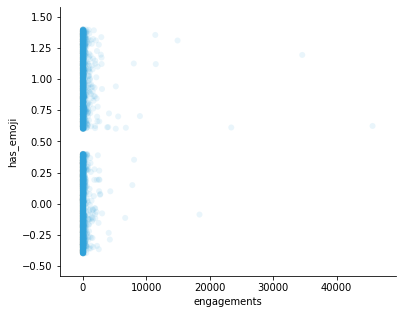

In [45]:
# # Style 1
# import hvplot 
# hvplot.extension('matplotlib')

# (
#     twit
#     .select(
#         'engagements',
#         # .cast(pl.Int8) converts T/F to 1 and 0
#         has_emoji=tweet_col.str.contains(non_ascii).cast(pl.Int8)
#     )
#     .pipe(lambda df: df.with_columns(jitter(df['has_emoji'], amount=.4)))
#     .plot.scatter(x='engagements', y='has_emoji', alpha=.1, width=width_pixels, height=height_pixels)
# )


import hvplot.pandas
import polars as pl
import numpy as np

# Ensure hvplot is using Matplotlib backend
hvplot.extension('matplotlib')

# Define jitter function if not already defined
def jitter(series, amount=0.4):
    return series + np.random.uniform(-amount, amount, len(series))

# def jitter(col, amount=.5):
#     return col + np.random.uniform(-amount, amount, len(col))
    
(
    twit
    .select(
        'engagements',
        # .cast(pl.Int8) converts T/F to 1 and 0
        has_emoji=tweet_col.str.contains(non_ascii).cast(pl.Int8)
    )
    .pipe(lambda df: df.with_columns(jitter(df['has_emoji'], amount=0.4)))
    .to_pandas()  # Convert Polars DataFrame to Pandas DataFrame
    .hvplot.scatter(
        x='engagements', 
        y='has_emoji', 
        alpha=0.1, 
        width=width_pixels, 
        height=height_pixels
    )
)

:Scatter   [engagements]   (has_emoji)
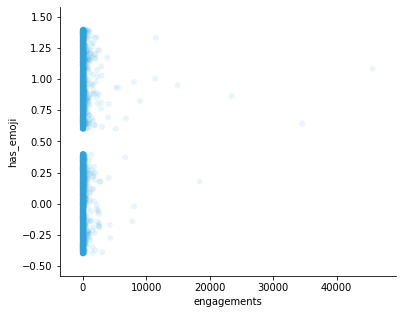

In [46]:
# Style 2
import hvplot.polars
hvplot.extension('matplotlib')

(
    twit
    .select(
        'engagements',
        # .cast(pl.Int8) converts T/F to 1 and 0
        has_emoji=tweet_col.str.contains(non_ascii).cast(pl.Int8)
    )
    .pipe(lambda df: df.with_columns(jitter(df['has_emoji'], amount=.4)))
    .hvplot.scatter(x='engagements', y='has_emoji', alpha=.1, width=width_pixels, height=height_pixels)
)

<Figure size 500x400 with 0 Axes>

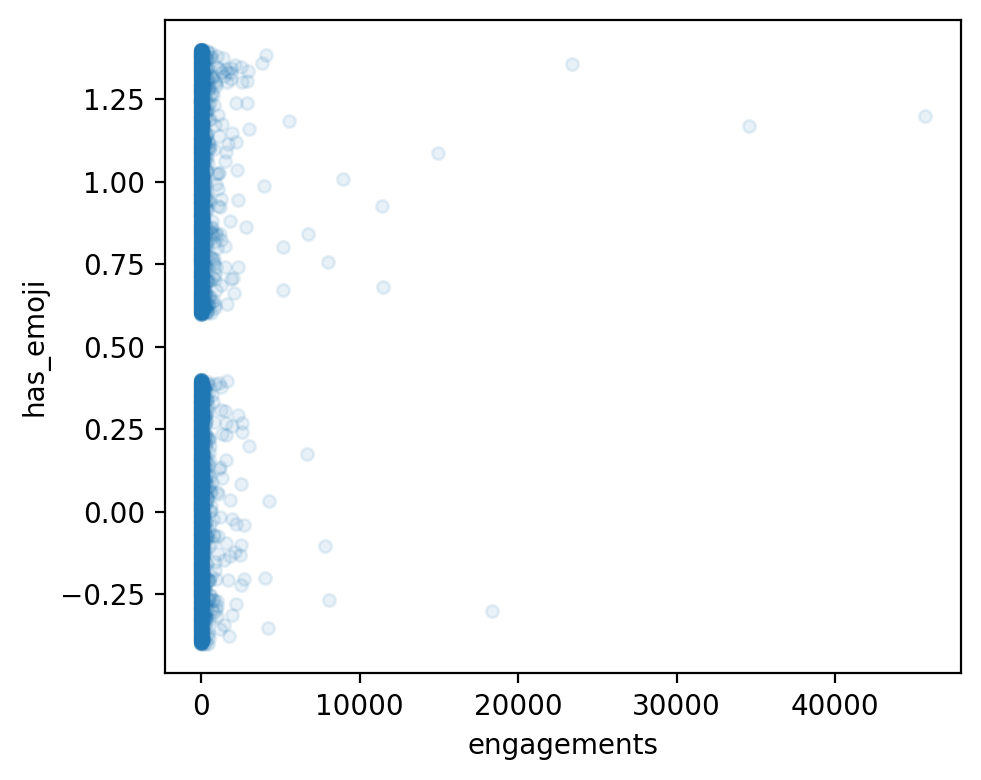

In [47]:
# style 3
import matplotlib
import matplotlib.pyplot as plt

# If earlier called hvplot.extension, need to run this below to reset settings
%matplotlib inline

corr_data = (
    twit
    .select(
        'engagements', 
        has_emoji=tweet_col.str.contains(non_ascii).cast(pl.Int8)
    )
    .pipe(lambda df: df.with_columns(jitter(df['has_emoji'], amount=.4)))
 )
corr_pandas_df = corr_data.to_pandas()

fig, ax = plt.subplots(figsize=(width_m,height_m))
corr_pandas_df.plot.scatter(
    x="engagements",
    y="has_emoji",
    alpha=.1,
    ax=ax
)

plt.tight_layout()

---
# 3.7 Plotting Trends
[back to Top](#Top)

* Plot the impressions over time for both tweets and replies.
* The data does not indicate whether the tweet is a reply or not.
* We can use `.str.starts_with()` to check if the tweet starts with @ to determine if the tweet is a reply.

In [48]:
(
    twit
    .select(
        'time', 
        'engagements',
        tweet_col,
        reply=tweet_col.str.starts_with('@')
    )
)

time,engagements,Tweet text,reply
str,f64,str,bool
"""2020-01-02 03:44:00+00:00""",7.0,"""Sounds like a great topic! htt…",false
"""2020-01-02 03:52:00+00:00""",3.0,"""@FogleBird Looks like SLC. I c…",true
"""2020-01-02 05:56:00+00:00""",6.0,"""@afilina That's really amount …",true
"""2020-01-03 01:41:00+00:00""",14.0,"""@randal_olson I use anaconda w…",true
"""2020-01-03 02:16:00+00:00""",1.0,"""@AlSweigart Sometimes the stud…",true
…,…,…,…
"""2021-12-27 03:01:00+00:00""",1.0,"""@allison_horst That's awesome!""",true
"""2021-12-27 17:25:00+00:00""",7.0,"""@willmcgugan You need to find …",true
"""2021-12-28 18:08:00+00:00""",12.0,"""@posco Visiting Hawaii for the…",true


Next,
* Convert the *time* column to a *datetime* type
* Then plot the impressions over time for both tweets and replies.
* If we pass the correct format string, `.str.to_datetime()` will convert the string to a date.

In [49]:
(
    twit
    .select(
        pl.col('time').str.to_datetime('%Y-%m-%d %H:%M:%S%z'),
        'engagements',
        reply=tweet_col.str.starts_with('@')
    )
    .pivot(
        index='time',
        on='reply',
        values='engagements',
        aggregate_function='sum'
    )
    .rename({
        'false': 'original',
        'true': 'reply'
    })
)

time,original,reply
"datetime[μs, UTC]",f64,f64
2020-01-02 03:44:00 UTC,7.0,null
2020-01-02 03:52:00 UTC,null,3.0
2020-01-02 05:56:00 UTC,null,6.0
2020-01-03 01:41:00 UTC,null,14.0
2020-01-03 02:16:00 UTC,null,1.0
…,…,…
2021-12-27 03:01:00 UTC,null,1.0
2021-12-27 17:25:00 UTC,null,7.0
2021-12-28 18:08:00 UTC,null,12.0


* We now have a column for the x-axis (time) and two columns for lines on the y-axis (original and reply). 
* We can use the plot method to plot the data.


## 3.7.1 hvPlot

[back to Top](#Top)

Polars using the hvPlot library for plotting.

When you import hvplot (e.g. import hvplot.pandas), it automatically loads the Bokeh backend.

hvplot.polars is a module that provides integration between the Polars DataFrame library and the hvPlot visualization library in Python. It allows you to create interactive plots directly from Polars DataFrames using the familiar Pandas-like plotting syntax.

With hvplot.polars, you can call the `.plot` or `.hvplot` method on a Polars DataFrame to generate various types of plots, such as scatter plots, line plots, bar charts, and more.

The hvplot.polars module leverages the powerful hvPlot library, which is built on top of the Bokeh visualization library, to create interactive and highly customizable plots in Jupyter notebooks and other web-based environments.

By integrating with hvplot.polars, Polars users can benefit from the rich plotting capabilities and seamless interactivity provided by hvPlot, without having to manually convert their DataFrames to other formats. This integration makes data exploration and visualization more convenient and efficient when working with Polars DataFrames.

---

hvplot.extension is a function in the hvPlot library that allows you to load and switch between different plotting backends or rendering engines. By default, hvPlot uses the Bokeh library for rendering interactive plots, but it also supports Matplotlib and Plotly as alternative backends. The main use cases for hvplot.extension are:

* Loading additional plotting backends: When you import hvplot (e.g. import hvplot.pandas), it automatically loads the Bokeh backend. To additionally load the Matplotlib or Plotly backends, you can use:

```python
import hvplot.pandas
hvplot.extension('matplotlib')  # Loads Matplotlib backend
hvplot.extension('plotly')  # Loads Plotly backend
hvplot.extension('matplotlib', 'plotly')  # Loads both backends
```

In [50]:
!pip list | grep hvplot
!pip list | grep bokeh

hvplot                        0.10.0
bokeh                         3.4.3


:NdOverlay   [Variable]
   :Curve   [time]   (value)
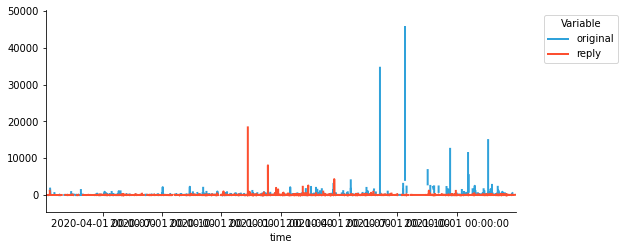

In [51]:
# new
import hvplot.polars
import polars as pl
import hvplot

hvplot.extension('matplotlib')

(
    twit
    .select(
        pl.col('time').str.to_datetime('%Y-%m-%d %H:%M:%S%z'),
        'engagements',
         reply=tweet_col.str.starts_with('@')
    )
    .pivot(
        index='time',
        on='reply',
        values='engagements',
        aggregate_function='sum'
    )
    .rename({
        'false': 'original',
        'true': 'reply'
    })
    .hvplot(
        kind='line',
        x='time',
        y=['original', 'reply']
    )
)

---
* This plot is rather hard to read.
* Some outliers are making it hard to see the trend.
* We could try plotting the log of the engagement values.
* However, we will aggregate the data to the weekly level and plot the weekly average engagements.

---
## 3.7.2 matplotlib

[back to Top](#Top)

:NdOverlay   [Variable]
   :Curve   [time]   (value)
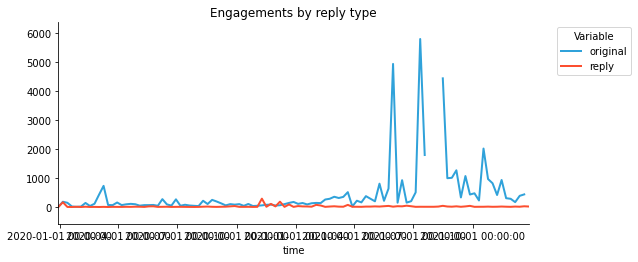

In [52]:
import hvplot.polars
import polars as pl

hvplot.extension('matplotlib')

(
    twit
    .select(
        pl.col('time').str.to_datetime('%Y-%m-%d %H:%M:%S%z'),
        'engagements',
        reply=tweet_col.str.starts_with('@')
    )
    .pivot(
        index='time',
        on='reply',
        values='engagements',
        aggregate_function='sum'
    )
    .sort('time')
    .group_by_dynamic('time', every='1w')
    .agg(pl.col(['true', 'false']).mean())
    .rename({
        'false': 'original',
        'true': 'reply'
    })
    .hvplot(
        kind='line',
        x='time',
        y=['original', 'reply'],
        title='Engagements by reply type'
    )
)


This shows that the number of engagements for original tweets is much higher than for replies, and it seems to be trending higher.

---
## 3.7.3 pandas plot

[back to Top](#Top)

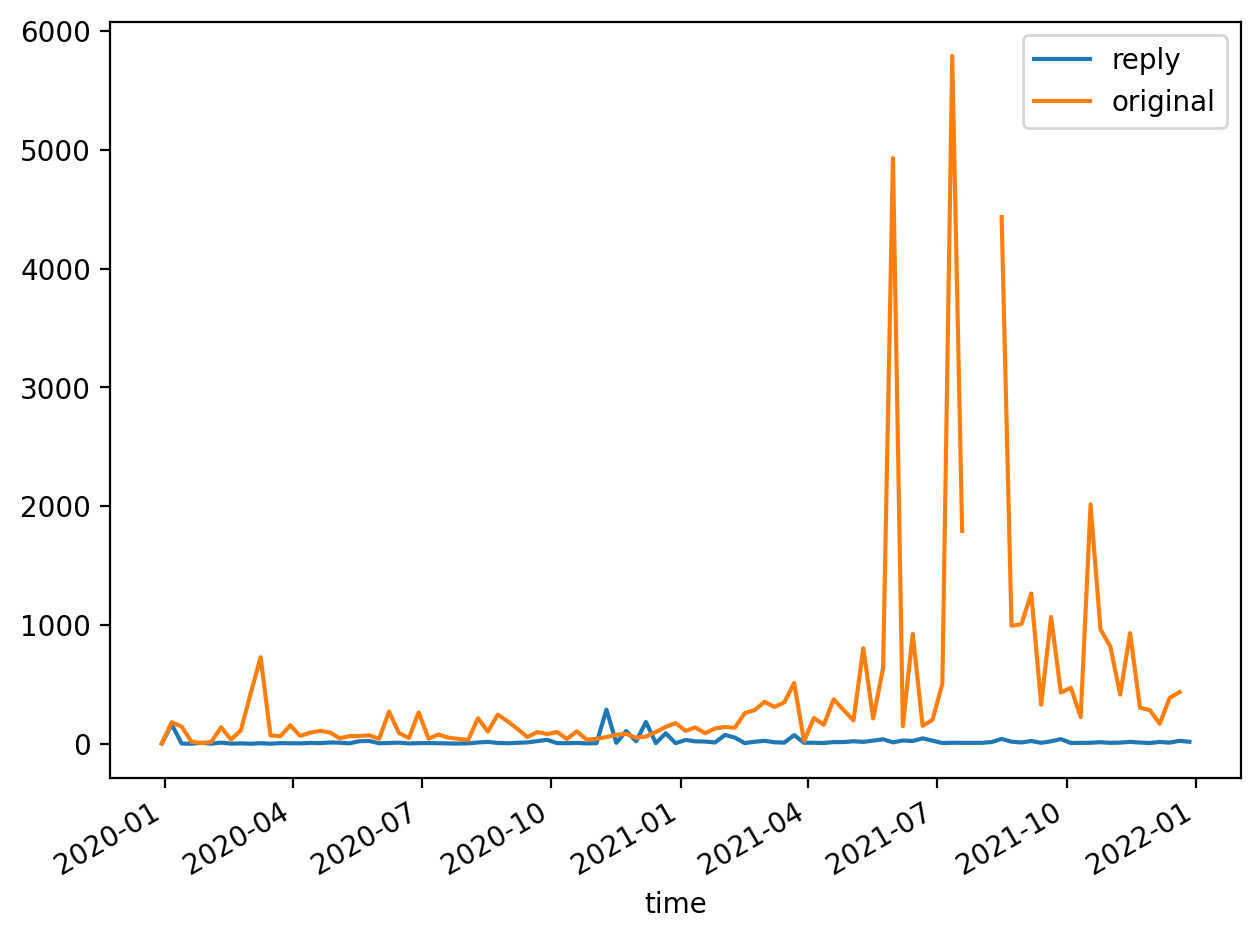

In [53]:
# Pandas plot version
plot_pandas = (
    twit
    .select(
        pl.col('time').str.to_datetime('%Y-%m-%d %H:%M:%S%z'),
        'engagements',
        reply=tweet_col.str.starts_with('@')
    )
    .pivot(
        index='time',
        on='reply',
        values='engagements',
        aggregate_function='sum'
    )
    .set_sorted('time')
    .group_by_dynamic('time', every='1w')
    .agg(pl.col('true', 'false').mean())
    .rename({
        'false': 'original',
        'true': 'reply'
    })
    .to_pandas()
)

# If earlier called hvplot.extension, need to run this below to reset settings
%matplotlib inline

(
    plot_pandas
    .set_index('time')
    .plot(kind='line')
)

plt.tight_layout()